# Estimating the stock beta via python

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pandas_datareader.data as reader
import datetime as dt
import statsmodels.api as sm

sns.set()
plt.style.use('dark_background')

In [64]:
end = dt.date(2021,1,1)
start = dt.date(end.year - 5, end.month, end.day)
Input = ['MSFT', '^GSPC']

In [65]:
df = reader.get_data_yahoo(Input,start,end)['Adj Close']
df

Symbols,MSFT,^GSPC
Date,,
2016-01-04,49.776890,2012.660034
2016-01-05,50.003983,2016.709961
2016-01-06,49.095642,1990.260010
2016-01-07,47.387970,1943.089966
2016-01-08,47.533310,1922.030029
...,...,...
2020-12-24,221.726166,3703.060059
2020-12-28,223.925995,3735.360107
2020-12-29,223.119720,3727.040039


## Monthly Returns

In [66]:
monthly_rets = df.resample('M').ffill().pct_change()
monthly_rets = monthly_rets.dropna(axis=0)
monthly_rets.head()

Symbols,MSFT,^GSPC
Date,,
2016-02-29,-0.069789,-0.004128
2016-03-31,0.085495,0.065991
2016-04-30,-0.097049,0.002699
2016-05-31,0.070197,0.015325
2016-06-30,-0.034528,0.000911


## Bulding the regression model

In [67]:
X = monthly_rets['^GSPC']
y = monthly_rets['MSFT']

# the intercept is not defined as default
X_sm = sm.add_constant(X)

In [68]:
X.shape, y.shape

((59,), (59,))

In [69]:
model = sm.OLS(y, X_sm)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MSFT   R-squared:                       0.475
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                     51.53
Date:                Fri, 04 Jun 2021   Prob (F-statistic):           1.61e-09
Time:                        00:21:02   Log-Likelihood:                 109.02
No. Observations:                  59   AIC:                            -214.0
Df Residuals:                      57   BIC:                            -209.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0167      0.005      3.175      0.002       0.006       0.027
^GSPC          0.8383      0.117      7.178      0.000       0.604       1.072
==============================================================================
Omnibus:                        2.111   Durbin-Watson:                   2.543
Prob(Omnibus):                  0.348   Jarque-Bera (JB):                1.301
Skew:                          -0.275   Prob(JB):                        0.522
Kurtosis:                       3.476   Cond. No.                         23.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Alfa = coef X const = 0,0191

Beta = coef X ^GSPC = 0,7896

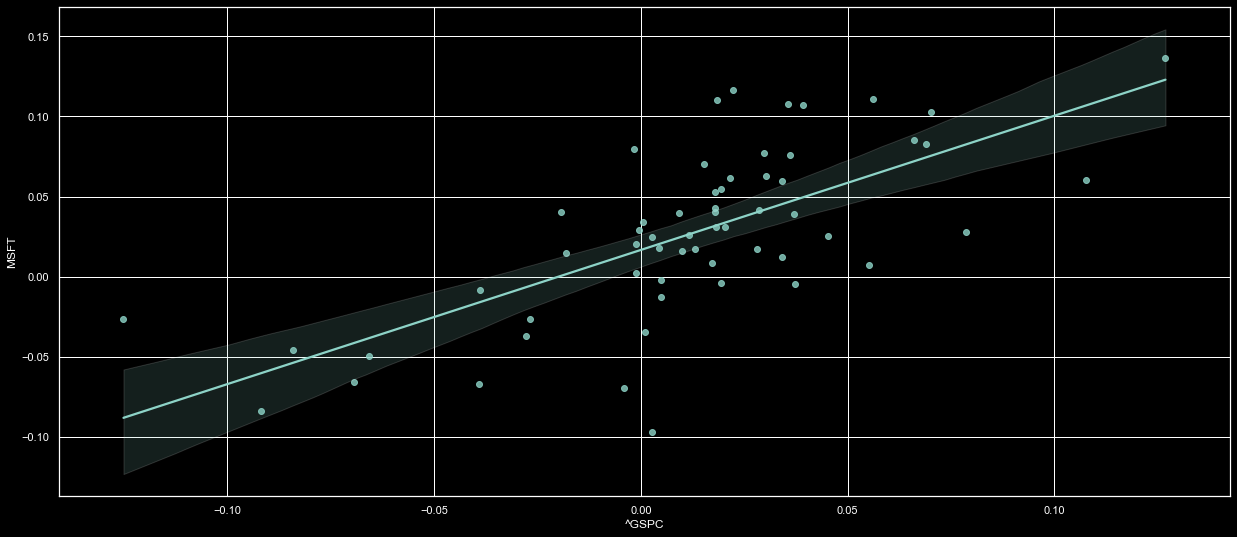

In [70]:
fig, ax = plt.subplots(figsize=(21,9))
sns.regplot(x='^GSPC', y='MSFT', data=monthly_rets, ci=95, ax=ax)  #ci is the Confidence Interval
plt.show()

## Taking the risk free rate

In [80]:
rf = reader.DataReader('F-F_Research_Data_Factors', 'famafrench',start,end)[0].RF
rf = rf[1:-1]
rf.head(5)

Date
2016-02    0.02
2016-03    0.02
2016-04    0.01
2016-05    0.01
2016-06    0.02
Freq: M, Name: RF, dtype: float64

In [81]:
rf.tail(5), rf.shape

(Date
 2020-08    0.01
 2020-09    0.01
 2020-10    0.01
 2020-11    0.01
 2020-12    0.01
 Freq: M, Name: RF, dtype: float64,
 (59,))

In [82]:
# Get the Excess Return

monthly_rets['MSFT-rf'], monthly_rets['^GSPC-rf'] = monthly_rets['MSFT'] - rf.values, monthly_rets['^GSPC'] - rf.values
monthly_rets.head()

Symbols,MSFT,^GSPC,MSFT-rf,^GSPC-rf
Date,,,,
2016-02-29,-0.069789,-0.004128,-0.089789,-0.024128
2016-03-31,0.085495,0.065991,0.065495,0.045991
2016-04-30,-0.097049,0.002699,-0.107049,-0.007301
2016-05-31,0.070197,0.015325,0.060197,0.005325
2016-06-30,-0.034528,0.000911,-0.054528,-0.019089


## Bulding the regression model again

In [83]:
X = monthly_rets['^GSPC-rf']
y = monthly_rets['MSFT-rf']

In [84]:
X_sm = sm.add_constant(X)

In [85]:
model = sm.OLS(y,X_sm)

In [86]:
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                MSFT-rf   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     257.7
Date:                Fri, 04 Jun 2021   Prob (F-statistic):           8.24e-23
Time:                        00:22:09   Log-Likelihood:                 110.12
No. Observations:                  59   AIC:                            -216.2
Df Residuals:                      57   BIC:                            -212.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0059      0.007      0.889      0.378      -0.007       0.019
^GSPC-rf       0.8874      0.055     16.053      0.000       0.777       0.998
==============================================================================
Omnibus:                        0.914   Durbin-Watson:                   2.611
Prob(Omnibus):                  0.633   Jarque-Bera (JB):                0.323
Skew:                          -0.050   Prob(JB):                        0.851
Kurtosis:                       3.349   Cond. No.                         11.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

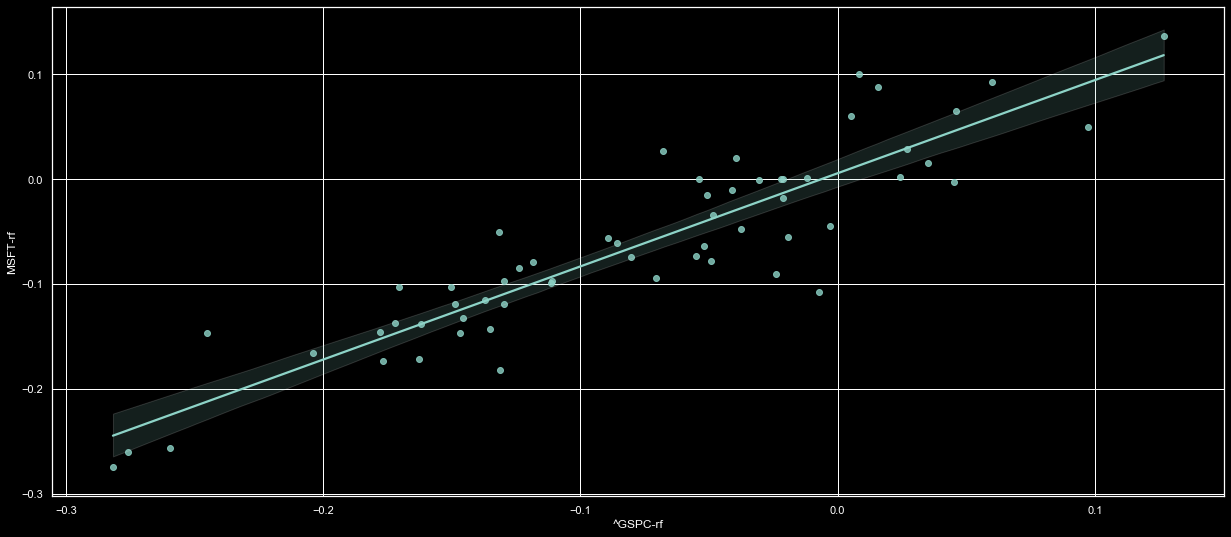

In [87]:
fig, ax = plt.subplots(figsize=(21,9))
sns.regplot(x='^GSPC-rf', y='MSFT-rf', data=monthly_rets, ci=95, ax=ax)  #ci is the Confidence Interval
plt.show()